## Loading, Preprocessing, and Transforming Steinmetz data

Code adapted from Neuromatch Academy (https://github.com/NeuromatchAcademy/course-content/tree/main/projects/neurons), includes some visualizations

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import KFold
from pyts.transformation import ShapeletTransform

In [2]:
# @title Figure settings
####### taken from Neuromatch Academy (https://github.com/NeuromatchAcademy/course-content/tree/main/projects/neurons)
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data retrieval
####### taken from Neuromatch Academy (https://github.com/NeuromatchAcademy/course-content/tree/main/projects/neurons)
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [4]:
# @title Data loading
####### taken from Neuromatch Academy (https://github.com/NeuromatchAcademy/course-content/tree/main/projects/neurons)
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

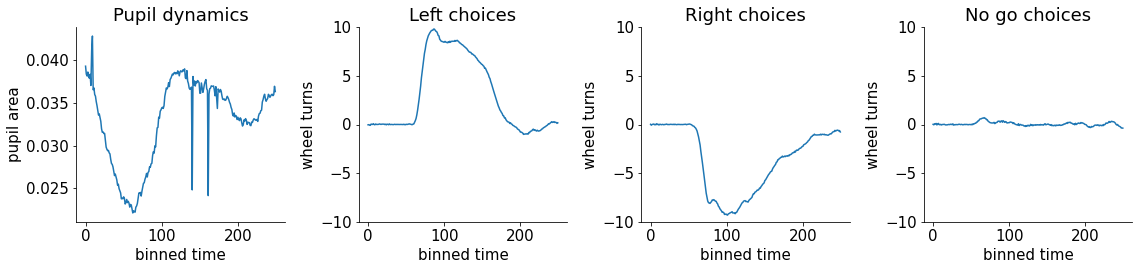

In [ ]:
####### taken from Neuromatch Academy (https://github.com/NeuromatchAcademy/course-content/tree/main/projects/neurons)
# select just one of the recordings here.
dat = alldat[11]
response = dat['response']
print(dat.keys())

# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel='binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1, 5, 2)
plt.plot(dat['wheel'][0, response > 0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Left choices')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Right choices')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='No go choices')
#plt.show()

In [ ]:
# Total number of trials
np.sum([np.shape(alldat[i]['feedback_type'])[0] for i in range(len(alldat))])

10050

In [ ]:
# Total number of trials where mouse response or guess was 'Go' (left or right)
np.sum([np.sum(alldat[i]['response'] != 0) for i in range(len(alldat))])

6745

In [ ]:
# Checking missing values
np.sum([np.sum(np.isnan(alldat[i]['wheel'])) for i in range(len(alldat))])
np.sum([np.sum(np.isnan(alldat[i]['pupil'])) for i in range(len(alldat))])
np.sum([np.sum(np.isnan(alldat[i]['face'])) for i in range(len(alldat))])

0

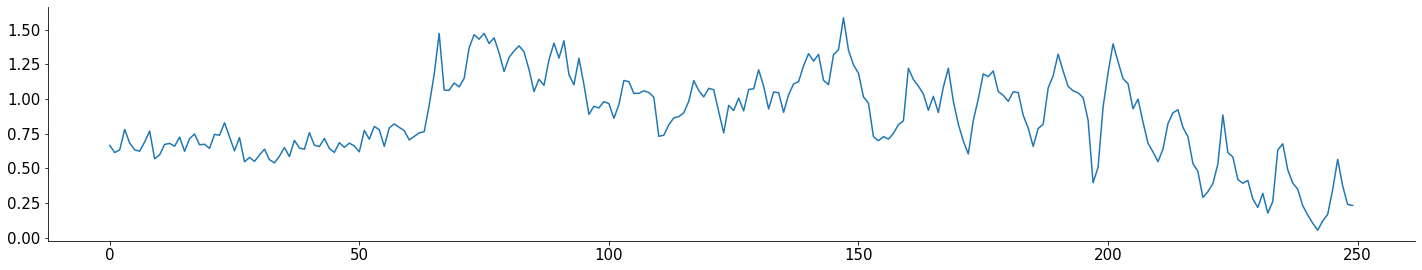

In [ ]:
#Example of a single trial for a single feature (pupil y-coordinate here). Note x-axis tick values reflect observation number not time (*10 - 500ms for time).
plt.plot(alldat[0]['pupil'][2,0,])

In [ ]:
#Pupil dictionary entry contains 3 features: size, x-coordinate, and y-coordinate
np.shape(alldat[1]['pupil'])

(3, 251, 250)

In [ ]:
# Total yields 10050 trials each with 250 observations
np.shape(np.concatenate(tuple([alldat[i]['wheel'][0,:,:] for i in range(len(alldat))]), axis = 0))

(10050, 250)

In [5]:
# Separating features for pupil into their own dictionary entries for processing
for i in range(len(alldat)):
  alldat[i]['pupil_area'] = np.reshape(alldat[i]['pupil'][0,:,:], (1,np.shape(alldat[i]['pupil'])[1],np.shape(alldat[i]['pupil'])[2]))
  alldat[i]['pupil_xcoord'] = np.reshape(alldat[i]['pupil'][1,:,:], (1,np.shape(alldat[i]['pupil'])[1],np.shape(alldat[i]['pupil'])[2]))
  alldat[i]['pupil_ycoord'] = np.reshape(alldat[i]['pupil'][2,:,:], (1,np.shape(alldat[i]['pupil'])[1],np.shape(alldat[i]['pupil'])[2]))

In [ ]:
# Total number of sessions
len(alldat)

39

In [8]:
def non_overlapping_mean(x, window=10):
    """Applies an averaging low-pass filter using a non-overlapping window

    Parameters
    ----------
    x : iterable
        The iterable of time-series trials to downsample
    window : int, optional
        The size of the non-overapping window over which the mean will be computed (default is
        10). NaNs are recorded when the window selects less than 2 observations

    Returns
    -------
    list
        a list with same length as x of downsampled time-series trials
    """
    return([pd.Series(i).groupby(np.arange(len(i)) // window).apply(lambda i: np.nan if len(i) < 2 else i.mean()).tolist() for i in x])

def concat(data, var_name):
  """Concatinates data (trials) from all mice and sessions for a given variable 

    Parameters
    ----------
    data : numpy array of dictionaries
        The complete dataset containing different features corresponding to different mice on different sessions
    var_name : string
        The name of the feature to be processed that matches a dictionary key

    Returns
    -------
    list
        a list with length equal to the total number of trials
    """
  return(np.concatenate(tuple([data[i][var_name][0,:,:] for i in range(len(data))]), axis = 0).tolist())

mice_idx = np.concatenate(tuple([np.repeat(alldat[i]['mouse_name'], len(alldat[i]['feedback_type'])) for i in range(len(alldat))]), axis = 0).tolist()
data = pd.DataFrame({'Mouse_ID': mice_idx,
                  'Wheel': non_overlapping_mean(concat(alldat, 'wheel'), 10),
                  'Face': non_overlapping_mean(concat(alldat, 'face'), 10), 
                  'Pupil_Area': non_overlapping_mean(concat(alldat, 'pupil_area'), 10),
                  'Pupil_Xcoord': non_overlapping_mean(concat(alldat, 'pupil_xcoord'), 10),
                  'Pupil_Ycoord': non_overlapping_mean(concat(alldat, 'pupil_ycoord'), 10)})
print(data.shape)

(10050, 6)
(10050, 1)


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Go_Trial    0.669552
dtype: float64

In [9]:
# Selecting label for the model (Go/NoGo status of trial in this case).

# commented line below is for the correctness of a mouse's guess (not used here)
#labels = pd.DataFrame({'Correct_Guess': np.concatenate(tuple([[1 if j == 1 else 0 for j in alldat[i]['feedback_type']] for i in range(len(alldat))]), axis = 0).tolist()})
labels = pd.DataFrame({'Go_Trial': np.array(np.concatenate(tuple([alldat[i]['contrast_right'] for i in range(len(alldat))]), axis = 0) != np.concatenate(tuple([alldat[i]['contrast_left'] for i in range(len(alldat))]), axis = 0), dtype= int).tolist()
                      })
print(labels.shape)
np.mean(labels)

(10050, 1)


Go_Trial    0.669552
dtype: float64

In [10]:
# Number of observations per trial after lowpass filtering with non-overlapping window
len(data.iloc[1,1])

25

In [11]:
#### 2000 randomly selected positive (Go) trials are removed to yield a more balanced dataset
np.random.seed(123)
down_sample_idx = np.random.choice(np.where(np.array(labels.iloc[:,0]) == 1)[0], 2000, replace = False).tolist()
data_balanced = data.drop(data.index[down_sample_idx])
labels_balanced = labels.drop(labels.index[down_sample_idx])
print(data_balanced.shape, labels_balanced.shape)
np.mean(labels_balanced)

(8050, 6) (8050, 1)


Go_Trial    0.587453
dtype: float64

In [12]:
#### Randomly select 20% of mice to be part of test set C
np.random.seed(123)
mouse_names = np.unique(mice_idx)
print(int(np.round(len(mouse_names)*0.2)))
test_mice_idx = np.random.choice(mouse_names, int(np.round(len(mouse_names)*0.2)), replace = False).tolist()

#### Subset data for training and testing
X = data_balanced.loc[[data_balanced.iloc[i,0] not in test_mice_idx for i in range(data_balanced.shape[0])], :].iloc[:,1:]
y = labels_balanced.loc[[data_balanced.iloc[i,0] not in test_mice_idx for i in range(data_balanced.shape[0])], :].reset_index(drop = True)
print(X.shape, y.shape)
X_test = data_balanced.loc[[data_balanced.iloc[i,0] in test_mice_idx for i in range(data_balanced.shape[0])], :].iloc[:,1:]
y_test = labels_balanced.loc[[data_balanced.iloc[i,0] in test_mice_idx for i in range(data_balanced.shape[0])], :].reset_index(drop = True)
print(X_test.shape, y_test.shape)

2
(7012, 5) (7012, 1)
(1038, 5) (1038, 1)


In [13]:
#### Apply top-k shapelet transform using 2 cores on each of the features considered to yield a total of 5*k features
k = 4 # how many top-k shapelets to select
w = [5] # window size
X_train_transformed = pd.DataFrame()
sfxs = ['Wheel', 'Face', 'Pupil_Area', 'Pupil_Xcoord', 'Pupil_Ycoord']
sts = [] # save transform objects to project testing data

for i in range(X.shape[1]):
    print("Feature " + str(i + 1))
    st = ShapeletTransform(n_shapelets=k, window_sizes=w, window_steps = w, random_state = 123, n_jobs = 2, sort = True, verbose = 1)
    res = pd.DataFrame(st.fit_transform(np.array(list(X.iloc[:,i])), np.array(y.iloc[:,0]))).add_suffix('_' + sfxs[i])
    sts.append(st)
    X_train_transformed = pd.concat([X_train_transformed, res], axis = 1)
    print("Done")
pd.concat([X_train_transformed, y], axis = 1).to_csv('~/Desktop/data_transformed_train.csv') # save the transformed training data to CSV
print(X_train_transformed.shape)

Feature 1


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   37.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  9.4min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 13.9min
[Parallel(n_jobs=2)]: Done 7012 out of 7012 | elapsed: 16.1min finished


Done
Feature 2


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   26.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  9.4min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 11.6min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done 7012 out of 7012 | elapsed: 16.2min finished


Done
Feature 3


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   26.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  9.6min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 11.7min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 14.1min
[Parallel(n_jobs=2)]: Done 7012 out of 7012 | elapsed: 16.3min finished


Done
Feature 4


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   27.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:  7.2min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  9.1min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 11.1min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 13.3min
[Parallel(n_jobs=2)]: Done 7012 out of 7012 | elapsed: 15.4min finished


Done
Feature 5


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   56.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 10.6min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 12.8min
[Parallel(n_jobs=2)]: Done 7012 out of 7012 | elapsed: 14.9min finished


Done


In [14]:
#### Project testing data onto the same shapelet transform learned for training for each feature
print(X_train_transformed.shape) 

X_test_transformed = pd.DataFrame()

for i in range(X_test.shape[1]):
    print("Feature " + str(i + 1))
    res = pd.DataFrame(sts[i].transform(np.array(list(X_test.iloc[:,i])))).add_suffix('_' + sfxs[i])
    X_test_transformed = pd.concat([X_test_transformed, res], axis = 1)
    print("Done")
pd.concat([X_test_transformed, y_test], axis = 1).to_csv('~/Desktop/data_transformed_test.csv') # save the transformed testing data to CSV
print(X_test_transformed.shape)

(7012, 20)
Feature 1
Done
Feature 2
Done
Feature 3
Done
Feature 4
Done
Feature 5
Done
(1038, 20)
